In [1]:
# Compile all the code for the paper 'Decreased UHI under warmer conditions'
# do only the period 2000-2016
# import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ulmo
import os
import scipy.stats
import matplotlib
import cartopy.crs as ccrs
import time
import cartopy.io.shapereader as shpreader
matplotlib.rcParams.update({'font.size': 18})

In [2]:
#import cartopy
print(np.__version__, pd.__version__, ulmo.__version__, scipy.__version__,
      matplotlib.__version__,) #cartopy.__version__)
import sys
print(sys.version)

('1.10.4', u'0.18.1', '0.8.3dev', '0.17.1', '1.5.1')
2.7.11 |Anaconda custom (x86_64)| (default, Dec  6 2015, 18:57:58) 
[GCC 4.2.1 (Apple Inc. build 5577)]


In [3]:
results_filename = 'US_results_cleaned_data.csv'
results_filepath = 'plots/version6/tmax/'

In [4]:
# functions
def prettify_plot(): 
    ""'Hides top and rightmos axis spines and also some other stuff. '""
    figures = [x for x in matplotlib._pylab_helpers.Gcf.get_all_fig_managers()]
    for figure in figures:
        # Get all Axis instances related to the figure.
        for ax in figure.canvas.figure.get_axes():
            # Disable spines.
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
            # Disable ticks.
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
    
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.set_axis_bgcolor('none')
    plt.grid(b=False, which='major')
    
def color_scatter_years(x,y,title, xlabel, ylabel): 
    fig, ax = plt.subplots()
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    cmap = plt.cm.get_cmap('Greys_r', 7)
    cax = ax.scatter(x[ind],y[ind], c = x[ind].index, cmap = cmap)# cmap = plt.cm.bone)
    #plt.scatter(x[ind],y[ind], c = x[ind].index, cmap = plt.cm.bone)
    cbar = fig.colorbar(cax, ticks=[1985,1995, 2005, 2015], orientation='horizontal')
    #plt.colorbar()
    cbar.ax.set_xticklabels(['1985','1995', '2005', '2015'])  # horizontal colorbar
    ax.plot(x, m*x+b, color = 'black')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    ax.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('r = %.2f'%(r), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('p = %.2f'%(p), xy=(.5, .7), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('N = %i'%(ind.shape), xy=(.5, .6), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m,r,p
def color_scatter(x,y,title, xlabel, ylabel): 
    fig, ax = plt.subplots()
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    cax = ax.scatter(x[ind],y[ind], c = x[ind].index, cmap = plt.cm.bone)
    #plt.scatter(x[ind],y[ind], c = x[ind].index, cmap = plt.cm.bone)
    cbar = fig.colorbar(cax, ticks=[6000,16800], orientation='horizontal')
    #plt.colorbar()
    cbar.ax.set_xticklabels(['1985', '2016'])  # horizontal colorbar
    ax.plot(x, m*x+b, color = 'black')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    ax.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m,r,p

# plotting 
# define functions used for plotting 
def lin_trend_plot(start_x, y,title, xlabel, ylabel) : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y.values)# & ~np.isnan(x) # subset values that aren't NaNs
    x = np.arange(0,y.shape[0])
    m, b, r_value, p, std_err = scipy.stats.linregress(x[ind],y[ind])
    plt.scatter(x+start_x,y)
    plt.plot(x+start_x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r_value), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, b, r_value, p, std_err

import scipy.stats
import scipy.stats.distributions as distributions
import random
import math
import collections
def linregress_mod(x, y= None, null_slope = 0) : 
    # modification of scipy.stats, using Adam Kurkiewicz's code from
    # https://github.com/scipy/scipy/issues/7074
    """
    Calculate a regression line
    This computes a least-squares regression for two sets of measurements.
    Parameters
    ----------
    x, y : array_like
        two sets of measurements.  Both arrays should have the same length.
        If only x is given (and y=None), then it must be a two-dimensional
        array where one dimension has length 2.  The two sets of measurements
        are then found by splitting the array along the length-2 dimension.
    Returns
    -------
    slope : float
        slope of the regression line
    intercept : float
        intercept of the regression line
    r-value : float
        correlation coefficient
    p-value : float
        two-sided p-value for a hypothesis test whose null hypothesis is
        that the slope is zero.
    stderr : float
        Standard error of the estimate

    """
    TINY = 1.0e-20
    if y is None:  # x is a (2, N) or (N, 2) shaped array_like
        x = np.asarray(x)
        if x.shape[0] == 2:
            x, y = x
        elif x.shape[1] == 2:
            x, y = x.T
        else:
            msg = "If only `x` is given as input, it has to be of shape (2, N) \
            or (N, 2), provided shape was %s" % str(x.shape)
            raise ValueError(msg)
    else:
        x = np.asarray(x)
        y = np.asarray(y)
    n = len(x)
    xmean = np.mean(x,None)
    ymean = np.mean(y,None)

    # average sum of squares:
    ssxm, ssxym, ssyxm, ssym = np.cov(x, y, bias=1).flat
    r_num = ssxym
    r_den = np.sqrt(ssxm*ssym)
    if r_den == 0.0:
        r = 0.0
    else:
        r = r_num / r_den
        # test for numerical error propagation
        if (r > 1.0):
            r = 1.0
        elif (r < -1.0):
            r = -1.0

    df = n-2
    t = r*np.sqrt(df/((1.0-r+TINY)*(1.0+r+TINY)))
    prob = distributions.t.sf(np.abs(t),df)*2
    slope = r_num / ssxm
    intercept = ymean - slope*xmean
    sterrest = np.sqrt((1-r*r)*ssym / ssxm / df)
    
    
    rr = lambda x: intercept + slope*x

    # Partial steps to compute Wald Statistic.
    # as in https://github.com/scipy/scipy/issues/7074, from Feb 2017
    # attribution: https://github.com/picrin
    # Adam Kurkiewicz, http://cv.adam.kurkiewicz.pl/
    XDiff = [X_i - xmean for X_i in x]
    XDiffSquared = [i*i for i in XDiff]
    YDiff = [Y_i - ymean for Y_i in y]
    
    errs = [yy - rr(xx) for xx, yy in zip(x, y)]
    errStd = math.sqrt((1/(n-2))*(sum([err**2 for err in errs])))
    XStd = math.sqrt((1/(n))*sum([diff**2 for diff in XDiff]))
    stdB1 = errStd / (XStd * math.sqrt(n))

    # Wald Statistic.
    W = (slope - null_slope)/stdB1
    # pvalue of Wald Test of B1 = 0.
    pvalueWald = 2*scipy.stats.norm.cdf(-abs(W))
    # pvalue of T test of B1 = 0.
    pvalueT = 2*distributions.t.sf(abs(W), n - 2)
    return slope, intercept, r, prob, sterrest, pvalueWald, pvalueT

def easy_scatter(x,y,title='', xlabel='', ylabel='') : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    #m,b = np.polyfit(x[ind],y[ind],1)
    #r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    #m, b, r, p, sterrest, pvalueWald, pvalueT =  linregress_mod(x[ind], y[ind], null_slope = 1)
    m, b, r, p, sterrest  =  scipy.stats.linregress(x[ind], y[ind])
    plt.scatter(x[ind],y[ind], color = 'grey')
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p

def easy_scatter_wald(x,y,title='', xlabel='', ylabel='') : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    #m,b = np.polyfit(x[ind],y[ind],1)
    #r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    m, b, r, p, sterrest, pvalueWald, pvalueT =  linregress_mod(x[ind], y[ind], null_slope = 1)
    plt.scatter(x[ind],y[ind], color = 'grey')
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(pvalueWald), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, b, r, p, pvalueWald, pvalueT#m, r, p

def map_hist_plot(data, paired_df, title = 'Response of $\Delta T$ to Temperature Change', data_label = 'm$_{JJA}$ ($^\circ$C$ / ^\circ $C)', label_city = False, c_insignificant = np.array([])) : 
    # plots a map and histogram of data, a pandas dataframe with cities in the index 
    # paired_df 
    # results_df[results_df['P-value']>0.05]
    fig = plt.figure(figsize=[15,7])
    ax = plt.axes([0, 0, 1, 1],
                       projection=ccrs.LambertConformal())
    ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
    ax.set_title(title)
    # download default shapefils from natura_earth using cartopy's shapereader
    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

    # to get the effect of having just the states without a map "background"
    # turn off the outline and background patches
    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)

    # Plot background state map
    for state in shpreader.Reader(states_shp).geometries():
        # pick a default color for the land with a black outline,
        # this will change if the storm intersects with our track
        facecolor = 'None'#[0.9375, 0.9375, 0.859375]
        edgecolor = 'black'
        ax.add_geometries([state], ccrs.PlateCarree(),
                          facecolor=facecolor, edgecolor=edgecolor, zorder = 0)

    # define data
    data = data[~np.isnan(data)]
    # Set up colors for plotting
    cmap = matplotlib.cm.coolwarm
    c = data
    bounds = np.linspace(0,2,11)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    marker_size = 150

    # plot data

    ax.set_title('a) ')
    # plot significance
    #c_insignificant = results_df[results_df['P-value']>0.05]
    if c_insignificant.shape[0] > 0 : 
        ax.scatter(paired_df.set_index('City').loc[c_insignificant.index]['Urban Lon'], paired_df.set_index('City').loc[c_insignificant.index]['Urban Lat'], 
                #paired_df['Urban Lon'].iloc[insig_inds], paired_df['Urban Lat'].iloc[insig_inds], 
                    c = c[c_insignificant.index].values, s = marker_size-50, 
                   transform=ccrs.Geodetic(),edgecolors= 'None',
                   cmap = cmap, norm = norm, zorder =1)        
        sig_cities = np.setdiff1d(paired_df.index,c_insignificant.index )
        plotHandle = ax.scatter(paired_df.set_index('City').loc[sig_cities]['Urban Lon'], 
                                paired_df.set_index('City').loc[sig_cities]['Urban Lat'], 
                            c = c[sig_cities].values, s = marker_size, alpha = 1, 
                            transform=ccrs.Geodetic(), edgecolors = 'darkgray', 
                     cmap = cmap,
                     norm = norm, zorder = 1, )
    else: 
        plotHandle = ax.scatter(paired_df.set_index('City').loc[c.index]['Urban Lon'], paired_df.set_index('City').loc[c.index]['Urban Lat'], 
                        c = c.values, s = marker_size, alpha = 1, 
                        transform=ccrs.Geodetic(), edgecolors = 'darkgray', 
                 cmap = cmap,
                 norm = norm, zorder = 1, )

    if label_city == True: 
        for city, lon, lat in zip(c.index, paired_df.set_index('City').loc[c.index]['Urban Lon'].values, paired_df.set_index('City').loc[c.index]['Urban Lat'].values): 
            if city != 'Honolulu': 
                ax.text(lon+.5,lat, city,
                        #xy = (paired_df.set_index('City').loc[c.index]['Rural Lon'].values, paired_df.set_index('City').loc[c.index]['Rural Lat'].values), 
                       transform = ccrs.Geodetic(), 
                        horizontalalignment='left',)


#     cb = plt.colorbar(plotHandle, label = data_label, #'Slope m$_{JJA}$ ($^\circ$C$ / ^\circ $C)',
#                       orientation='horizontal', shrink = .5)
#     cb.outline.remove()

    ##### Histogram 
    sub_ax = plt.axes([0.05, 0.0, 0.22, 0.25])
    #plot data
    n, bins, patches = sub_ax.hist(data,10, facecolor = 'darkgray', linewidth=0)
    # annotate and label 
    sub_ax.annotate('$ \mu = %2.2f $'%data.mean(), xy=(1.0, .3), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    sub_ax.annotate('$ \sigma  = %2.2f $'%data.std(), xy=(1.0, .15), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    sub_ax.annotate('range = $%2.2f, %2.2f $'%(data.min(), data.max()), xy=(1.0, 0), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    sub_ax.set_xlabel(data_label) #'m$_{JJA}$ ($^\circ$C$ / ^\circ $C)')
    sub_ax.set_ylabel('Count')
    sub_ax.set_title('b)')
    if data.max() < 0.1 : 
        sub_ax.set_xticks(sub_ax.get_xticks()[::2])

    # set histogram colors 
    m = matplotlib.cm.ScalarMappable(norm = norm, cmap = cmap)
    m._A = []

    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    for c,p in zip(bin_centers, patches): # in range(np.size(patches)):
        plt.setp(p,'facecolor', m.to_rgba(c))#color=m.to_rgba(c))
    #plt.colorbar(m)
    prettify_plot()
    return fig, ax, sub_ax

In [5]:
paired_df = pd.read_csv('USpairs2005-2015.csv').set_index('City', drop = False)
paired_df = paired_df[paired_df['Urban distance'] < 0.25]

In [8]:
# Calculate the relationship between summertime  UHI and t_, save it out for every city

#heatwave composite
composite_t = np.ones([paired_df.shape[0], 11])*np.nan
composite_UHI = np.ones([paired_df.shape[0], 11])*np.nan

numhw = 150
finalhw = 50

In [16]:
# Summertime UHI and temperature
results_df = pd.DataFrame([], index = paired_df.index, 
                          columns=['slope', 'r', 'pvalueWald', 'pvalueT', # daily JJA analysis
                                  'anom_slope', 'anom_r', 'anom_pvalueWald', 'anom_pvalueT', # daily anomaly JJA analysis
                                  'mean UHI', 'mean rural', 'mean urban', # long term means
                                   'mean_summer_tvsdt_m', 'mean_summer_tvsdt_r', 'mean_summer_tvsdt_p', # not really sure what for
                                  'trend_r', 'trend_r_p', 'trend_u', 'trend_u_p', # interannual trend
                                   'hw_slope', 'hw_r', 'hw_pvalueWald', 'hw_pvalueT', # heatwave slopes
                                  ])
compositehw_r_df = pd.DataFrame(np.ones([paired_df.shape[0], 11])*np.nan, index = paired_df.index)
compositehw_u_df = pd.DataFrame(np.ones([paired_df.shape[0], 11])*np.nan, index = paired_df.index)

toc = time.time() #time

for city in paired_df.index:
    urbanID = paired_df.loc[city]['Urban station']
    ruralID = paired_df.loc[city]['Rural station']
    print(city)
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    #drop data with flags here!!!
    if ('TMAX' in urbandata.keys()) & ('TMAX' in ruraldata.keys()) & (np.intersect1d(urbandata['TMAX']['2000-01-01':].index, ruraldata['TMAX']['2000-01-01':].index).shape[0] > 300): 
        ######
        ###### Import data
        ######
        rural_t = pd.to_numeric(ruraldata['TMAX']['2000-01-01':].value/10.) #rural t
        urban_t = pd.to_numeric(urbandata['TMAX']['2000-01-01':].value/10.) 
        
        # drop data with flags here
        rural_t.loc[ruraldata['TMAX']['2000-01-01':]['qflag'].dropna().index] = np.nan
        urban_t.loc[urbandata['TMAX']['2000-01-01':]['qflag'].dropna().index] = np.nan
        
        # extract summertime data 
        rural_summer = rural_t[(rural_t.index.month >= 6) & (rural_t.index.month <= 8)]
        urban_summer = urban_t[(urban_t.index.month >= 6) & (urban_t.index.month <= 8)]
        
        # clean data: eliate  temperatures below 4 or above 35
#         rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
#         urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]
        
        #calculate UHI
        UHI = urban_summer - rural_summer
        
        ######
        ###### Daily summertime analysis
        ######
        a = rural_summer[UHI.index]
        b = urban_summer[UHI.index]
        a = a[~np.isnan(a) & ~np.isnan(b)]
        b = b[~np.isnan(a) & ~np.isnan(b)].values
        
        plt.figure()
        slope, intercept, r, p, pvalueWald, pvalueT = easy_scatter_wald(a.values, b, '%s'%city, ' $T_r$ ($^\circ $C)', '$T_u$ ($^\circ $C)')
        plt.plot(a.values, a.values, color = 'lightblue')
        plt.legend(['Best fit', 'y=x'])
        plt.savefig('plots/version6/rural_vs_urban/%s.png'%city)
        plt.close()
        
        # save out daily summertime results 
        results_df.loc[city, ['slope', 'r', 'pvalueWald', 'pvalueT']] = slope, r, pvalueWald, pvalueT    
        
        ######
        ###### Anomaly daily summertime analysis
        ######
        
        rural_clim = rural_summer.groupby(rural_summer.index.year).mean() # compute rural climatology
        x = rural_summer - rural_clim[rural_summer.index.year].values # anomaly rural temperature
        urban_clim = urban_summer.groupby(urban_summer.index.year).mean() #compute urban climatology
        y = urban_summer - urban_clim[urban_summer.index.year].values # anomaly rural temperature

        plt.figure()
        slope, intercept, r, p, pvalueWald, pvalueT  = easy_scatter_wald(x,y, '%s'%city, ' $T_r ^\prime$ ($^\circ $C)', '$T_u  ^\prime$ ($^\circ $C)')
        plt.plot(x.values, x.values, color = 'lightblue')
        plt.legend(['Best fit', 'y=x'])
        plt.savefig('plots/version6/rural_vs_urban/anomalydaily%s.png'%city)
        plt.close()
        # save out daily summertime results 
        results_df.loc[city, ['anom_slope', 'anom_r', 'anom_pvalueWald', 'anom_pvalueT']] = slope, r, pvalueWald, pvalueT 

        ######
        ###### JJA mean of daily summertime analysis
        ######
        
                
        
        ######
        ###### Mean summertime analysis
        ######
        results_df.loc[city,['mean UHI', 'mean rural', 'mean urban',]] = UHI.mean(), rural_summer.mean(), urban_summer.mean()

        # plot summer mean values against each other 
        x = rural_summer.groupby(rural_summer.index.year).mean()
        y = urban_summer.groupby(urban_summer.index.year).mean()
        ind = ~np.isnan(y) & ~np.isnan(x)

        m,r,p = color_scatter_years(x[ind], y[ind], 
                      '%s Summer Mean JJA Temp versus Summer Mean$\Delta T$'%city, 
                      '$T_r$ ($^\circ$C)', 
                      '$T_u$ ($ ^\circ$ C)')
        plt.savefig(results_filepath+ 'summermeans/'+'summermeanTvDT%s%s.png'%(city.replace(" ", "")[0:5], ''))
        plt.close()
        
        results_df.loc[city,['mean_summer_tvsdt_m', 'mean_summer_tvsdt_r', 'mean_summer_tvsdt_p']] = m,r,p
        
        ######
        ###### Compute interanual trends
        ######

        try:
            title = '%s 30 yr trend in '%city
            fig = plt.figure(figsize=[10,4] )
            plt.subplot(121)
            slopeT, interceptT, r_valueT, pT, std_errT = lin_trend_plot(2000,rural_summer.groupby(rural_summer.index.year).mean(),'a) ' + title + '$T_r$', 'Years since 1985','Mean JJA $T_r$')
            plt.subplot(122)
            slope, intercept, r_value, p, std_err = lin_trend_plot(2000, UHI.groupby(UHI.index.year).mean(),'b) ' + title + '$\Delta T$', 'Years since 1985', 'Mean JJA $\Delta T$')
            plt.savefig(results_filepath+ 'trend/%s.png'%city)
            plt.close()
            
            slopeU, interceptU, r_valueU, pU, std_errU = lin_trend_plot(2000, urban_summer.groupby(urban_summer.index.year).mean(),'b) ' + title + '$\Delta T$', 'Years since 1985', 'Mean JJA $\Delta T$')
            plt.close()
            
        except ValueError:
            slopeT, interceptT, r_valueT, pT, std_errT= np.ones(5)*np.nan
            slope, intercept, r_value, p, std_err = np.ones(5)*np.nan

        # save out
        results_df.loc[city, ['trend_r', 'trend_r_p', 'trend_u', 'trend_u_p']] = slopeT, p, slopeU, pU

        ######
        ###### Compute average heatwave
        ######
        
        hottest = rural_summer.iloc[(-rural_summer.values).argsort()[:numhw]] 
        heatwaves = hottest[0:12]
        
        ### make sure that heatwaves aren't duplicates
        Ns = []
        m = 0 
        for n in range(1,10): 
            old = m
            try: 
                while heatwaves.sort_index().index[m+1].to_timestamp() - heatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                    m = m+1
            except IndexError: 
                heatwaves = hottest[0:20]
                try: 
                    while heatwaves.sort_index().index[m+1].to_timestamp() - heatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                        m = m+1
                except IndexError: 
                    print('out of bounds')
            try: 
                if old ==m : 
                    Ns.append(heatwaves.sort_index().index[m])
                else: 
                    Ns.append(heatwaves.sort_index()[old:m].argmax())
            except: 
                'random error'
            m = m+1
            
        ######
        ###### Compute the worst heatwaves
        ######
        
        finalhw = hottest[Ns].sort_values(ascending=False)
        compositeTemp = np.nan*np.ones([finalhw.shape[0], 11])
        compositeU = np.nan*np.ones([finalhw.shape[0], 11])
        ii = 0
        for dates in finalhw.index[:]: 
            try: 
                compositeTemp[ii,:]= rural_t[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
                compositeU[ii,:] = (urban_t)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values# -UHI[dates.to_timestamp()]
            except : 
                print('skipping %s'%dates)
            ii = ii+1
        plt.figure(figsize=[12,4])
        plt.subplot(1,2,1)
        tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
        plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), linewidth = 3, color = 'black')
        plt.title(' %s rural'%(city))
        plt.ylabel('Temp. ($^\circ C$)')
        plt.xlabel('Heatwave Day')

        plt.subplot(1,2,2)    
        uhiHandle = plt.plot(np.arange(-5,6,1),compositeU.T, '-o')
        plt.plot(np.arange(-5,6,1),np.nanmean(compositeU, axis=0), linewidth = 3,color = 'black')
        plt.title(' %s urban'%(city))
        plt.ylabel('Temp ($ ^\circ C$)')
        plt.xlabel('Heatwave Day')
        plt.legend(heatwaves.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))
        plt.savefig(results_filepath+''+'hwcomposite%s'%city.replace(" ", "")[0:5]+'.pdf',  bbox_inches='tight')        # save out 
        plt.close()
        compositehw_r_df.loc[city] = np.nanmean(compositeTemp, axis=0)
        compositehw_u_df.loc[city] = np.nanmean(compositeU, axis=0)

        ######
        ###### Analyze heatwave data
        ######
        x = rural_summer
        y = urban_summer
        ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs

        #heatwaves
        hw_x = rural_summer[hottest.index]#[np.logical_or(rural_t.index.month==6, rural_t.index.month==7, rural_t.index.month==8)] 
        hw_y = urban_summer[hottest.index]#[np.logical_or(UHI.index.month==6, UHI.index.month==7, UHI.index.month==8)] 
        hw_ind = ~np.isnan(hw_y) & ~np.isnan(hw_x) # subset values that aren't NaNs

        # plot heatwave temps
        plt.figure()
        slope, intercept, r, p, pvalueWald, pvalueT = easy_scatter_wald(hw_x[hw_ind],hw_y[hw_ind], 
                                                                        'Heatwave %s'%city, ' $T_r$ ($^\circ $C)', '$T_u$ ($^\circ $C)')
        plt.plot(hw_x, hw_x, color = 'lightblue')
        plt.legend(['Best fit', 'y=x'])
        plt.savefig('plots/version6/rural_vs_urban/hw%s%s.png'%(city, ''))
        plt.close()
        
        # save out daily summertime results 
        results_df.loc[city, ['hw_slope', 'hw_r', 'hw_pvalueWald', 'hw_pvalueT']] = slope, r, pvalueWald, pvalueT 
        
        ######
        ###### Save out the data
        ######
        
        results_df.to_csv(results_filepath + results_filename)
        # Save out the mean temperature and UHI
                    
results_df = results_df.astype(float)
tic = time.time()
print('Elapsed time: ', tic-toc)

Mesa


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


skipping 2001-07-02
Grand Prairie


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Irvine


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Fort Lauderdale


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Long Beach


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Hartford


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Providence


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

Virginia Beach


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Oakland


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


West Palm Beach


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

out of bounds
out of bounds
Louisville


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Columbus


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


San Bernardino


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


St. Paul


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Tucson


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Fresno


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Albuquerque


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Kansas City


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Ft. Worth


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

Austin


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


skipping 2003-08-08
Indianapolis


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


out of bounds
Baltimore


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

San Jose


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Sacramento


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Las Vegas


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


out of bounds
Portland


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Salt Lake City


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


out of bounds
Omaha


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Raleigh


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Cleveland


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Cincinnati


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


out of bounds
out of bounds
Nashville


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


out of bounds
out of bounds
out of bounds
out of bounds
Memphis


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Norfolk


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Milwaukee


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


out of bounds
out of bounds
Buffalo


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Pittsburgh


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Minneapolis


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Honolulu


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Seattle


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Phoenix


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


San Diego


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


St. Louis


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


out of bounds
out of bounds
New Orleans


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Dallas


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

Philadelphia


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Detroit


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


San Francisco


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

Denver


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Miami


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Chicago


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


Los Angeles


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

Washington, D.C.


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


New York


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

out of bounds
Elapsed time:  9133.260140895844


In [6]:
results_df = pd.read_csv(results_filepath + results_filename).set_index('City').loc[paired_df.index]
results_df.head()

,slope,r,pvalueWald,pvalueT,anom_slope,anom_r,anom_pvalueWald,anom_pvalueT,mean UHI,mean rural,...,mean_summer_tvsdt_r,mean_summer_tvsdt_p,trend_r,trend_r_p,trend_u,trend_u_p,hw_slope,hw_r,hw_pvalueWald,hw_pvalueT
City,,,,,,,,,,,,,,,,,,,,,
Mesa,0.980422,0.889116,1.664872e-01,1.667299e-01,0.992814,0.895889,6.027006e-01,6.027911e-01,0.945918,39.940159,...,0.454996,8.835857e-02,0.006088,0.354685,0.033587,0.131748,0.713754,0.408565,0.044741,0.046898
Grand Prairie,0.672976,0.720027,7.665956e-76,9.360399e-68,0.626406,0.675664,8.292104e-89,6.500304e-78,-0.372347,34.660772,...,0.937234,2.586536e-07,0.061570,0.784903,0.037131,0.611986,0.341794,0.244465,0.000003,0.000009
Irvine,0.675352,0.878621,8.267578e-264,2.253352e-195,0.702969,0.916192,0.000000e+00,1.493854e-222,-1.207073,29.632502,...,0.530091,2.861317e-02,-0.159693,0.000004,0.050191,0.360780,0.952275,0.640138,0.611439,0.612195
Fort Lauderdale,0.317800,0.374164,1.520158e-230,1.739386e-172,0.309753,0.364955,1.824249e-234,1.019329e-174,-1.474982,33.285990,...,0.305228,2.335264e-01,0.019429,0.302796,0.077358,0.004846,0.270069,0.114561,0.000150,0.000217
Long Beach,0.468140,0.498884,3.267738e-147,7.465621e-123,0.479705,0.518848,3.944933e-149,3.405271e-124,-1.397569,28.301536,...,0.159873,5.399234e-01,-0.007625,0.381731,0.043771,0.377732,-0.035442,-0.011630,0.000036,0.000059


/Users/annascott2/anaconda2/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


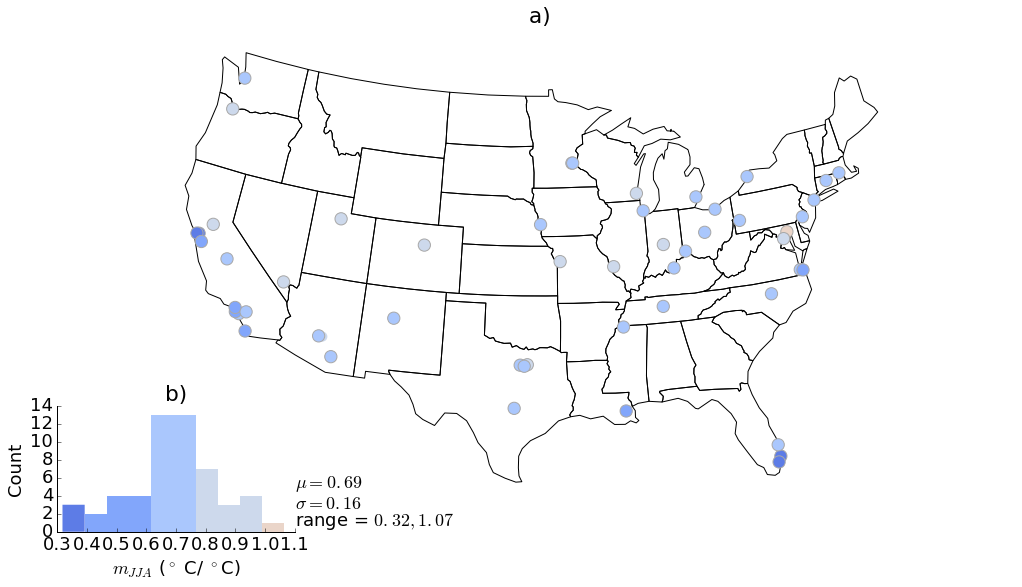

In [7]:
data = results_df['slope']
fig, ax, sub_ax = map_hist_plot(data, paired_df, title = '$T_{max}', 
                    data_label='$m_{JJA}$ ($^\circ$ C/ $^\circ $C)',
                   c_insignificant = results_df[results_df['pvalueT']>0.05]
                ) 
#sub_ax.set_xticks(sub_ax.get_xticks()[::2])
plt.savefig(results_filepath+ 'TMAX_slope.pdf', bbox_inches='tight')

/Users/ascott47/anaconda/lib/python3.6/site-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/cultural/ne_110m_ad_1_states_provinces_lakes_shp.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


HTTPError: HTTP Error 404: Not Found

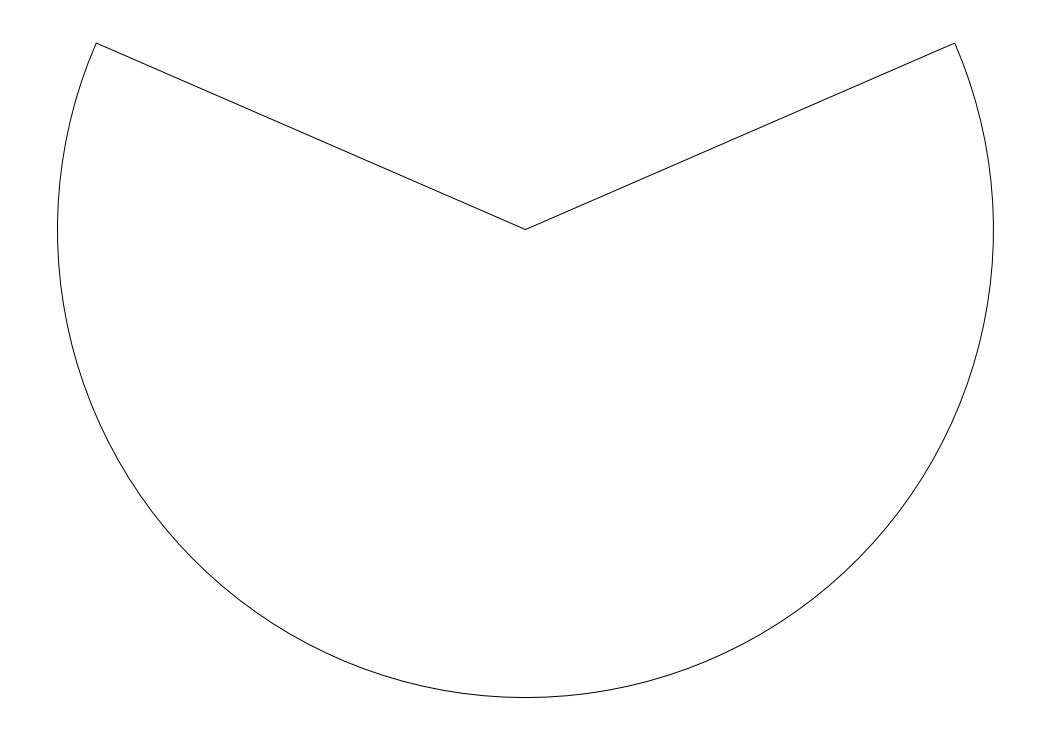

In [50]:
# fig 1 
### map plot

def inset_scatter(x,y,title='', xlabel='', ylabel='') : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    #m,b = np.polyfit(x[ind],y[ind],1)
    #r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    m, b, r, p, sterrest, pvalueWald, pvalueT =  linregress_mod(x[ind], y[ind], null_slope = 1)
    plt.scatter(x[ind],y[ind], color = 'grey')
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.1, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
#    plt.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
#    plt.annotate('p = %.2f'%(pvalueWald), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
#    plt.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, b, r, p, pvalueWald, pvalueT#m, r, p


fig = plt.figure(figsize=[15,10])
#ax = fig.add_subplot(224, projection=ccrs.LambertConformal())
ax = plt.axes([0, 0, 1, 1],
                    projection=ccrs.LambertConformal())
shapename = 'ad_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

# to get the effect of having just the states without a map "background"
# turn off the outline and background patches
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
# Plot background state map
for state in shpreader.Reader(states_shp).geometries():
    # pick a default color for the land with a black outline,
    # this will change if the storm intersects with our track
    facecolor = 'None'#[0.9375, 0.9375, 0.859375]
    edgecolor = 'black'
    ax.add_geometries([state], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor, zorder = 0)

# define data
data = results_df['slope']
data = data[~np.isnan(data)]
# Set up colors for plotting
cmap = matplotlib.cm.coolwarm
c = data
bounds = np.linspace(0,2,11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
marker_size = 150

# plot data
plotHandle = ax.scatter(paired_df.set_index('City').loc[c.index]['Urban Lon'], paired_df.set_index('City').loc[c.index]['Urban Lat'], 
                        c = c.values, s = marker_size, alpha = 1, 
                        transform=ccrs.Geodetic(), edgecolors = 'darkgray', 
                 cmap = cmap,
                 norm = norm, zorder = 1, )
plt.title('d)')

######
dummy_ind = 0
for city in ['Baltimore', 'Miami']:
    
    urbanID = paired_df.loc[city]['Urban station']
    ruralID = paired_df.loc[city]['Rural station']
    print(city)
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    ######
    ###### Import data
    ######
    rural_t = pd.to_numeric(ruraldata['TMAX']['2000-01-01':].value/10.) #rural t
    urban_t = pd.to_numeric(urbandata['TMAX']['2000-01-01':].value/10.) 

    # drop data with flags here
    rural_t.loc[ruraldata['TMAX']['2000-01-01':]['qflag'].dropna().index] = np.nan
    urban_t.loc[urbandata['TMAX']['2000-01-01':]['qflag'].dropna().index] = np.nan

    # extract summertime data 
    rural_summer = rural_t[(rural_t.index.month >= 6) & (rural_t.index.month <= 8)]
    urban_summer = urban_t[(urban_t.index.month >= 6) & (urban_t.index.month <= 8)]

#     # clean data: eliate  temperatures below 4 or above 35
#     rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
#     urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]
        
    #calculate UHI
    UHI = urban_summer - rural_summer
        
    ######
    ###### Daily summertime analysis
    ######
    a = rural_summer[UHI.index]
    b = urban_summer[UHI.index]
    a = a[~np.isnan(a) & ~np.isnan(b)]
    b = b[~np.isnan(a) & ~np.isnan(b)].values

    if dummy_ind ==0 : 
        #sub_ax1 = plt.axes([0.0, 1.0, 0.25, 0.35])
        sub_ax2 = plt.axes([0.33, 1.0, 0.25, 0.35])

        #sub_ax3 = plt.axes([0.9, 0.0, 0.25, 0.35])
        inset_scatter(a.values, b,'b) %s'%(city),
                  '$T_r$  ($^\circ$ C)', '$ T_u$ ($^\circ$ C)') 
        plt.plot(a.values, a.values, color = 'lightblue')
        plt.legend(['Best fit', 'y=x'], loc =4)
    else: 
        sub_ax1 = plt.axes([0.0, 1.0, 0.25, 0.35])

        #sub_ax2 = plt.axes([0.9, 0.6, 0.25, 0.35])
        inset_scatter(a.values, b,'a) %s'%(city),
                  '$T_r$  ($^\circ$ C)', '$ T_u$ ($^\circ$ C)') 
        plt.plot(a.values, a.values, color = 'lightblue')
        plt.legend(['Best fit', 'y=x'])
    ##### Inset plot     
    dummy_ind = dummy_ind+1
    


sub_ax = plt.axes([0.67, 1.0, 0.25, 0.35])#plt.subplot2grid((3,3), (0,3))
n, bins, patches = sub_ax.hist(data,10, facecolor = 'darkgray', linewidth=0)
# annotate and label 
sub_ax.annotate('$ \mu = %2.2f $'%data.mean(), xy=(0.01, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
sub_ax.annotate('$ \sigma  = %2.2f $'%data.std(), xy=(0.01, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
sub_ax.annotate('range = $%2.2f, %2.2f $'%(data.min(), data.max()), xy=(0.01, .6), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
sub_ax.set_xlabel('$m_{day}$ ($^\circ$ C/ $^\circ$ C)')#data_label) #'m$_{JJA}$ ($^\circ$C$ / ^\circ $C)')
sub_ax.set_ylabel('Count')
sub_ax.set_title('c)')

# set colors 
m = matplotlib.cm.ScalarMappable(norm = norm, cmap = cmap)
m._A = []

bin_centers = 0.5 * (bins[:-1] + bins[1:])
for c,p in zip(bin_centers, patches): # in range(np.size(patches)):
    plt.setp(p,'facecolor', m.to_rgba(c))#color=m.to_rgba(c))
plt.savefig(results_filepath+ 'figure01.pdf', bbox_inches='tight')

Baltimore


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vi

Miami


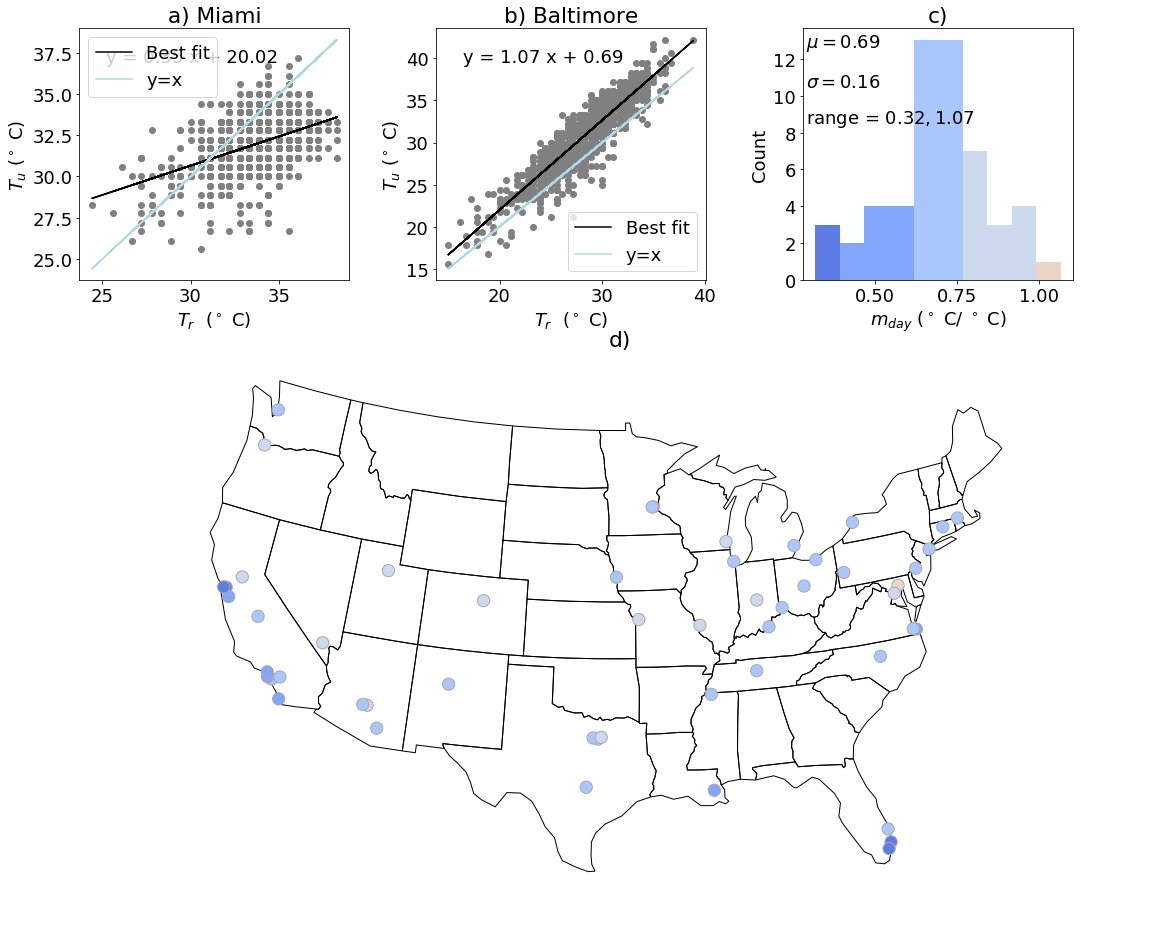

In [23]:
# fig 1 
### map plot

def inset_scatter(x,y,title='', xlabel='', ylabel='') : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    #m,b = np.polyfit(x[ind],y[ind],1)
    #r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    m, b, r, p, sterrest, pvalueWald, pvalueT =  linregress_mod(x[ind], y[ind], null_slope = 1)
    plt.scatter(x[ind],y[ind], color = 'grey')
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.1, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
#    plt.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
#    plt.annotate('p = %.2f'%(pvalueWald), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
#    plt.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, b, r, p, pvalueWald, pvalueT#m, r, p


fig = plt.figure(figsize=[15,10])
#ax = fig.add_subplot(224, projection=ccrs.LambertConformal())
ax = plt.axes([0, 0, 1, 1],
                    projection=ccrs.LambertConformal())
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

# to get the effect of having just the states without a map "background"
# turn off the outline and background patches
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
# Plot background state map
for state in shpreader.Reader(states_shp).geometries():
    # pick a default color for the land with a black outline,
    # this will change if the storm intersects with our track
    facecolor = 'None'#[0.9375, 0.9375, 0.859375]
    edgecolor = 'black'
    ax.add_geometries([state], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor, zorder = 0)

    
# define data
data = results_df['slope']
data = data[~np.isnan(data)]
# Set up colors for plotting
cmap = matplotlib.cm.coolwarm
c = data
bounds = np.linspace(0,2,11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
marker_size = 150

# plot data
plotHandle = ax.scatter(paired_df.set_index('City').loc[c.index]['Urban Lon'], paired_df.set_index('City').loc[c.index]['Urban Lat'], 
                        c = c.values, s = marker_size, alpha = 1, 
                        transform=ccrs.Geodetic(), edgecolors = 'darkgray', 
                 cmap = cmap,
                 norm = norm, zorder = 1, )
plt.title('d)')

dummy_ind = 0
for city in ['Baltimore', 'Miami']:
    
    urbanID = paired_df.loc[city]['Urban station']
    ruralID = paired_df.loc[city]['Rural station']
    print(city)
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    ######
    ###### Import data
    ######
    rural_t = pd.to_numeric(ruraldata['TMAX']['2000-01-01':].value/10.) #rural t
    urban_t = pd.to_numeric(urbandata['TMAX']['2000-01-01':].value/10.) 

    # drop data with flags here
    rural_t.loc[ruraldata['TMAX']['2000-01-01':]['qflag'].dropna().index] = np.nan
    urban_t.loc[urbandata['TMAX']['2000-01-01':]['qflag'].dropna().index] = np.nan

    # extract summertime data 
    rural_summer = rural_t[(rural_t.index.month >= 6) & (rural_t.index.month <= 8)]
    urban_summer = urban_t[(urban_t.index.month >= 6) & (urban_t.index.month <= 8)]

#     # clean data: eliate  temperatures below 4 or above 35
#     rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
#     urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]
        
    #calculate UHI
    UHI = urban_summer - rural_summer
        
    ######
    ###### Daily summertime analysis
    ######
    a = rural_summer[UHI.index]
    b = urban_summer[UHI.index]
    a = a[~np.isnan(a) & ~np.isnan(b)]
    b = b[~np.isnan(a) & ~np.isnan(b)].values

    if dummy_ind ==0 : 
        #sub_ax1 = plt.axes([0.0, 1.0, 0.25, 0.35])
        sub_ax2 = plt.axes([0.33, 1.0, 0.25, 0.35])

        #sub_ax3 = plt.axes([0.9, 0.0, 0.25, 0.35])
        inset_scatter(a.values, b,'b) %s'%(city),
                  '$T_r$  ($^\circ$ C)', '$ T_u$ ($^\circ$ C)') 
        plt.plot(a.values, a.values, color = 'lightblue')
        plt.legend(['Best fit', 'y=x'], loc =4)
    else: 
        sub_ax1 = plt.axes([0.0, 1.0, 0.25, 0.35])

        #sub_ax2 = plt.axes([0.9, 0.6, 0.25, 0.35])
        inset_scatter(a.values, b,'a) %s'%(city),
                  '$T_r$  ($^\circ$ C)', '$ T_u$ ($^\circ$ C)') 
        plt.plot(a.values, a.values, color = 'lightblue')
        plt.legend(['Best fit', 'y=x'])
    ##### Inset plot     
    dummy_ind = dummy_ind+1
    


sub_ax = plt.axes([0.67, 1.0, 0.25, 0.35])#plt.subplot2grid((3,3), (0,3))
n, bins, patches = sub_ax.hist(data,10, facecolor = 'darkgray', linewidth=0)
# annotate and label 
sub_ax.annotate('$ \mu = %2.2f $'%data.mean(), xy=(0.01, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
sub_ax.annotate('$ \sigma  = %2.2f $'%data.std(), xy=(0.01, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
sub_ax.annotate('range = $%2.2f, %2.2f $'%(data.min(), data.max()), xy=(0.01, .6), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
sub_ax.set_xlabel('$m_{day}$ ($^\circ$ C/ $^\circ$ C)')#data_label) #'m$_{JJA}$ ($^\circ$C$ / ^\circ $C)')
sub_ax.set_ylabel('Count')
sub_ax.set_title('c)')

# set colors 
m = matplotlib.cm.ScalarMappable(norm = norm, cmap = cmap)
m._A = []

bin_centers = 0.5 * (bins[:-1] + bins[1:])
for c,p in zip(bin_centers, patches): # in range(np.size(patches)):
    plt.setp(p,'facecolor', m.to_rgba(c))#color=m.to_rgba(c))
plt.savefig(results_filepath+ 'figure01.pdf', bbox_inches='tight')

In [25]:
results_df.head()

,slope,r,pvalueWald,pvalueT,anom_slope,anom_r,anom_pvalueWald,anom_pvalueT,mean UHI,mean rural,...,mean_summer_tvsdt_r,mean_summer_tvsdt_p,trend_r,trend_r_p,trend_u,trend_u_p,hw_slope,hw_r,hw_pvalueWald,hw_pvalueT
City,,,,,,,,,,,,,,,,,,,,,
Mesa,0.980422,0.889116,1.664872e-01,1.667299e-01,0.992814,0.895889,6.027006e-01,6.027911e-01,0.945918,39.940159,...,0.454996,8.835857e-02,0.006088,0.354685,0.033587,0.131748,0.713754,0.408565,0.044741,0.046898
Grand Prairie,0.672976,0.720027,7.665956e-76,9.360399e-68,0.626406,0.675664,8.292104e-89,6.500304e-78,-0.372347,34.660772,...,0.937234,2.586536e-07,0.061570,0.784903,0.037131,0.611986,0.341794,0.244465,0.000003,0.000009
Irvine,0.675352,0.878621,8.267578e-264,2.253352e-195,0.702969,0.916192,0.000000e+00,1.493854e-222,-1.207073,29.632502,...,0.530091,2.861317e-02,-0.159693,0.000004,0.050191,0.360780,0.952275,0.640138,0.611439,0.612195
Fort Lauderdale,0.317800,0.374164,1.520158e-230,1.739386e-172,0.309753,0.364955,1.824249e-234,1.019329e-174,-1.474982,33.285990,...,0.305228,2.335264e-01,0.019429,0.302796,0.077358,0.004846,0.270069,0.114561,0.000150,0.000217
Long Beach,0.468140,0.498884,3.267738e-147,7.465621e-123,0.479705,0.518848,3.944933e-149,3.405271e-124,-1.397569,28.301536,...,0.159873,5.399234e-01,-0.007625,0.381731,0.043771,0.377732,-0.035442,-0.011630,0.000036,0.000059


/Users/ascott47/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


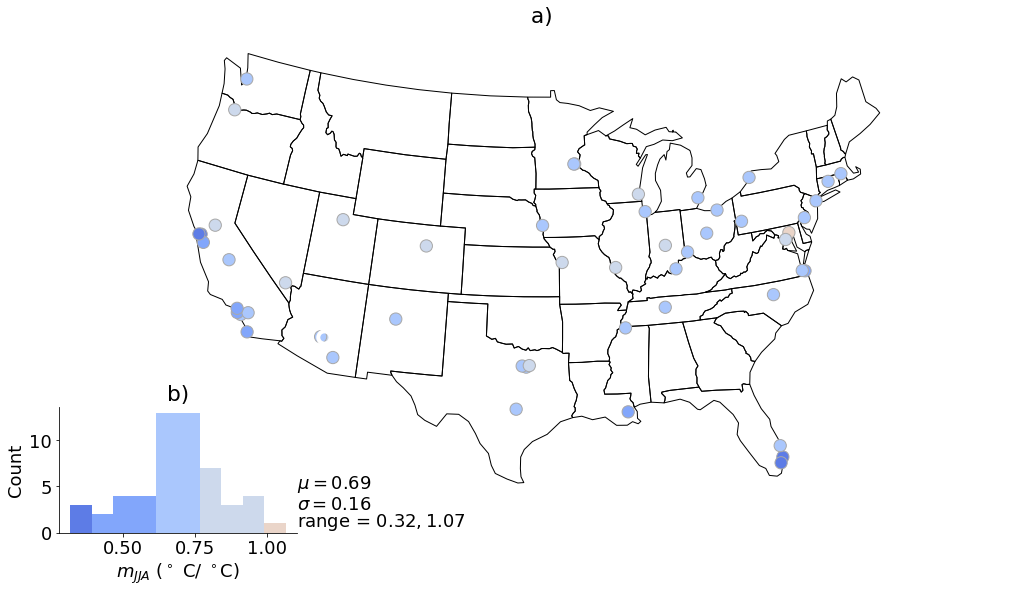

In [53]:
data = results_df['slope']
fig, ax, sub_ax = map_hist_plot(data, paired_df, title = '$T_{max}', 
                    data_label='$m_{JJA}$ ($^\circ$ C/ $^\circ $C)',
                   c_insignificant = results_df[results_df['pvalueT']>0.05]
                ) 
#sub_ax.set_xticks(sub_ax.get_xticks()[::2])
plt.savefig(results_filepath+ 'slope.pdf', bbox_inches='tight')

In [ ]:
# # fig 2 : heatwaves + heatwave sensitivity
compositeUDF = 
compositeTDF = 

plt.figure(figsize=[15,14])
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', plt.cm.Set2(np.linspace(0.0,0.75,10)))))
bmorec = 'k'
plt.subplot(2,2,1)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), '--', 
         color = bmorec, 
         linewidth = 4, )
plt.title('a) %s Heatwave Temperature'%(city))
plt.ylabel('$T_r$ ($^\circ C$)')
plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
#plt.legend(legend_str,loc = 2)
prettify_plot()

plt.subplot(2,2,2)    
uhiHandle = plt.plot(np.arange(-5,6,1),compositeU.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeU, axis=0),
         '--',color = bmorec, linewidth = 4, label = 'Composite Mean Event'),#color = 'black',)

plt.title('b) %s Heatwave $\Delta T$'%(city))
plt.ylabel('$\Delta T $ ($ ^\circ C$)')
plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
prettify_plot()
i = 0
for date in heatwaves.index: 
    if ~np.isnan(compositeU[i][10]): 
        if i ==0 : 
            plt.text(5, compositeU[i][10]-.8, date, color = tHandle[i].get_color()) # 1994-08-03
        elif i ==3: 
            plt.text(5, compositeU[i][10]-.8, date, color = tHandle[i].get_color())#, color = plt.cm.viridis(i)) 1993-07-08
        elif i ==7: 
            plt.text(5, compositeU[i][10]+.4, date, color = tHandle[i].get_color())# 1993-07-08
        else: 
            plt.text(5, compositeU[i][10], date, color = tHandle[i].get_color())#, verticalalignment='center', horizontalalignment='left')#, color = plt.cm.viridis(i))
    else: 
        plt.text(1, compositeU[i][6]+1, date, verticalalignment='top', horizontalalignment='center', color = tHandle[i].get_color())#, color = 'red')#plt.cm.viridis(i))

    i = i+1
plt.text(5,np.nanmean(compositeU, axis=0)[9]-1.7, 'Composite Mean', color = 'black')

x = np.arange(-5,6)
# plot heatwave composites for all stations
#plt.figure(figsize = [15,5])
#plot temperature,raw
plt.subplot(2,2,3)
for i in range(0, compositeTempDF.shape[0]) : 
    #print compositeUDF2.iloc[i].values[1:]
    plt.plot(x, compositeTempDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')

#plt.errorbar(x,compositeTempDF.mean(), yerr=compositeTempDF.std(), color = 'k', zorder = 1)
#compositeTempDF.mean(axis=0).plot(yerr = compositeTempDF.std(axis=0))
plt.plot(x, compositeTempDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
plt.plot(x, compositeTempDF.loc['Phoenix'], ':', color = 'k', alpha = 1, linewidth = 4, label = 'Phoenix')
plt.plot(x, compositeTempDF.loc['Albuquerque'], '-.', color = 'k', alpha = 1, linewidth = 2, label = 'Albuquerque')
plt.plot(x, compositeTempDF.loc['San Jose'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, label = 'San Jose')

plt.plot( x, compositeTempDF.mean(), '-o', color = 'k', linewidth = 4)
plt.xlabel('Heatwave Day')
plt.ylabel('$T_r$ ($^\circ$C)')
plt.title('c) Heatwave Temperature')
plt.xlim([-5,5])
xx = -5
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='left')

xx = 0
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'), 
         verticalalignment='center', horizontalalignment='center'
                 )
xx = 5
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='right')

# plt.text(2,compositeTempDF.loc[compositeTempDF.mean(axis=1).arg()][4],'%s'%compositeTempDF.mean(axis=1).arg())
# plt.text(2,compositeTempDF.loc[compositeTempDF.mean(axis=1).argmax()][4],'%s'%compositeTempDF.mean(axis=1).argmax())
# plt.text(2,compositeTempDF.loc['Baltimore'][4],'Baltimore', color = bmorec, zorder = 0)
prettify_plot()

#plot UHI, raw
plt.subplot(2,2,4)

for i in range(0, compositeUDF.shape[0]) : 
    #print compositeUDF2.iloc[i].values[1:]
    plt.plot(x, compositeUDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')
plt.plot( x, compositeUDF.mean(), '-o', color = 'k', linewidth = 4,)
#plt.errorbar(x,compositeUDF.mean(), yerr=compositeUDF.std(), color = 'k', zorder = 1)
plt.axhline(0, linestyle = ':', color = 'k')

plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
plt.ylabel('$\Delta T$ ($^\circ$C)')
plt.title('d) Heatwave UHI Composite')
prettify_plot()

xx = -5
yy = compositeUDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='left')

xx = 0
yy = compositeUDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'), 
         verticalalignment='center', horizontalalignment='center'
                 )
xx = 5
yy = compositeUDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='right')

plt.text(5,compositeUDF.loc[compositeUDF.mean(axis=1).arg()][4],'%s'%compositeUDF.mean(axis=1).arg())
plt.text(5,compositeUDF.loc[compositeUDF.mean(axis=1).argmax()][4],'%s'%compositeUDF.mean(axis=1).argmax())
plt.text(5,compositeUDF.loc['Baltimore'][4],'Baltimore', color = bmorec)
plt.text(5,compositeUDF.loc['Phoenix'][4],'Phoenix', color = 'k')
plt.text(5, compositeUDF.mean()[5], 'Mean', color = 'k', weight = 'bold')

plt.plot(x, compositeUDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
plt.plot(x, compositeUDF.loc['Albuquerque'], '-.', color = 'k', alpha = 1, linewidth = 2, label = 'Albuquerque')
plt.plot(x, compositeUDF.loc['San Jose'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, label = 'San Jose')
plt.plot(x, compositeUDF.loc['Phoenix'], ':', color = 'k', zorder = 0, alpha = 1, linewidth = 4, label = 'Phoenix')

plt.legend(loc = 'center left', bbox_to_anchor=(1.0, 0.5))

plt.savefig(results_filepath+ 'hwcompositeT.pdf',bbox_inches='tight')

# extreme heatwave sensitivity map
data = results_df['hw_slope']
fig, ax, sub_ax = map_hist_plot(data, paired_df, title = 'Heatwaves', 
                    data_label='Change of $\Delta T$ during Heatwaves, $\Delta_{hw}$ ($^\circ$ C/ $^\circ $C)',
                   c_insignificant = results_df[results_df['hw_pvalueWald']>0.05]
                ) 
sub_ax.set_xticks(sub_ax.get_xticks()[::2])
plt.savefig(results_filepath+ 'avg_hw_map.pdf', bbox_inches='tight')

In [ ]:
# fig 3: dry-moist analysis

/Users/ascott47/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


0.20882580547


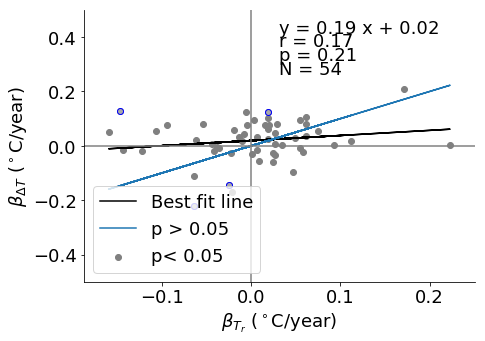

In [54]:
# fig 4 : changes over time 
# plot mean urban trends versus mean rural trends
x = results_df['trend_r']
y =  results_df['trend_u']
plt.figure(figsize=[7,5])
# plt.errorbar(x, y, yerr = slopes_std, fmt='o', alpha = .5,#markersize='10', 
#              color = 'DarkGray', zorder =0)

m, r, p = easy_scatter(results_df['trend_r'].values,results_df['trend_u'].values,
           '', r'$\beta_{T_r}$ ($^\circ$C/year)', #30-year JJA Trend Relationship
           r'$\beta_{\Delta T}$ ($^\circ$C/year)')
plt.plot(x,x)

plt.scatter(results_df[(results_df['trend_r_p'] < .05) & (results_df['trend_u_p']<.05)]['trend_r'], 
           results_df[(results_df['trend_r_p'] < .05) & (results_df['trend_u_p']<.05)]['trend_u'], 
           color = 'darkgray', edgecolor = 'blue', zorder =1)

plt.legend(['Best fit line', 'p > 0.05', 'p< 0.05'], loc = 3)

plt.axhline(0, color = 'gray')
plt.axvline(0, color = 'gray')
plt.ylim([-0.5,.5])
prettify_plot()
plt.savefig(results_filepath+'figure03_15years.pdf', bbox_inches='tight')
print(p)

/Users/ascott47/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


1.18097218683e-12


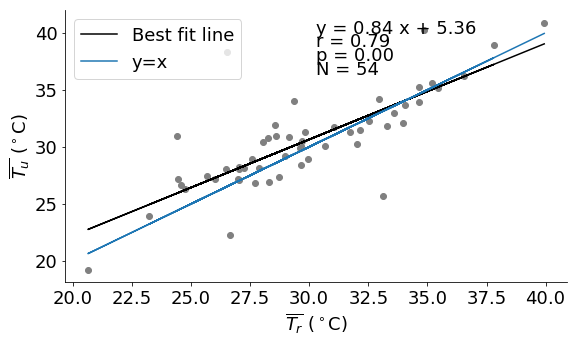

In [55]:
# fig 4 : changes over space
# plot mean urban versus mean rural
plt.figure(figsize=[9,5])
x = results_df['mean rural']
y = results_df['mean urban']
#plt.errorbar(x, y, yerr = UHI_std, fmt='o', color = 'DarkGray')
m,r,p = easy_scatter(x.dropna().astype(float),y.dropna().astype(float),
             '', 
             '$\overline{T_r}$ ($^\circ$C)', '$\overline{T_u}$ ($^\circ$C)')
plt.plot(x,x)
prettify_plot()
plt.legend(['Best fit line', 'y=x'], loc = 2)
plt.savefig(results_filepath+ 'figure04.pdf',bbox_inches='tight')
print(p)

/Users/ascott47/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


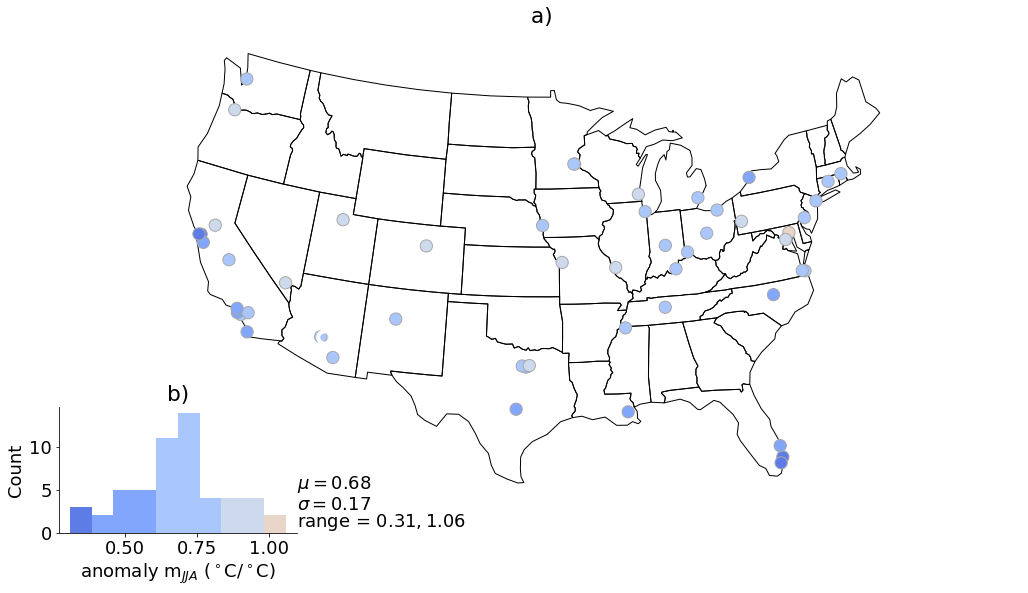

In [56]:
#### supplemental figures

data = results_df['anom_slope']#.drop(drop_cities, axis = 0)['Anomaly m']
fig = map_hist_plot(data, paired_df, title = 'Response of Anomaly $\Delta T$ to Temperature Change', 
                    data_label = 'anomaly m$_{JJA}$ ($^\circ$C$ / ^\circ $C)', 
                   c_insignificant = results_df[results_df['anom_pvalueT']>0.05]) 
plt.savefig(results_filepath+ 'anomalyJJAslopes.pdf', bbox_inches='tight')

/Users/ascott47/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


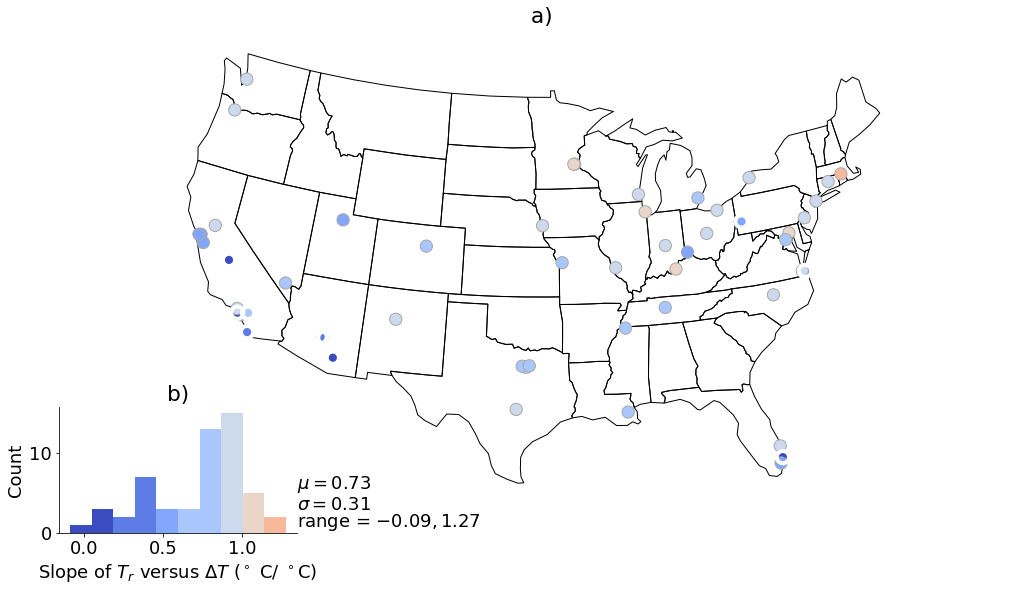

In [57]:
# change over time: summer annual temps versus UHI
data = results_df['mean_summer_tvsdt_m']
fig = map_hist_plot(data, paired_df, title = 'Slope of summer mean $T_r$ versus $T_u$', 
                    data_label='Slope of $T_r$ versus $\Delta T$ ($^\circ$ C/ $^\circ $C)', 
                  c_insignificant = results_df[results_df['mean_summer_tvsdt_p']>0.05]) 
plt.savefig(results_filepath+ 'summer_mean_slopes.pdf', bbox_inches='tight')